# ML Model to predit rideshare trip fare

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
# white, dark, whitegrid, darkgrid, ticks

# Loading Dataset

In [43]:
raw_df = pd.read_csv("trips_clean.csv")
df = raw_df.copy()
df

,DURATION,DISTANCE,FARE,IS_POOLED,TRIPS_POOLED
0,1131.0,3.8,12.50,False,1
1,816.0,2.0,13.05,False,1
2,755.0,1.5,10.05,False,1
3,231.0,1.1,7.55,False,1
4,489.0,1.4,8.55,False,1
...,...,...,...,...,...
962700,360.0,0.9,5.72,False,1
962701,426.0,3.4,12.05,False,1
962702,782.0,2.7,10.05,False,1
962703,451.0,1.2,7.55,False,1


## Data Statistics

In [44]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, "f")))

,DURATION,DISTANCE,FARE,TRIPS_POOLED
count,962705.000000,962705.000000,962705.000000,962705.000000
mean,1010.771792,5.323332,13.695692,1.277437
std,636.816667,5.013243,8.284358,0.753383
min,3.000000,0.100000,0.670000,1.000000
25%,533.000000,1.800000,7.550000,1.000000
50%,852.000000,3.500000,10.600000,1.000000
75%,1339.000000,6.900000,16.000000,1.000000
max,3450.000000,26.600000,49.910000,24.000000


## Correlation of features in dataset

In [45]:
df.corr()

,DURATION,DISTANCE,FARE,IS_POOLED,TRIPS_POOLED
DURATION,1.000000,0.807099,0.720275,0.134702,0.199882
DISTANCE,0.807099,1.000000,0.841301,0.044978,0.061162
FARE,0.720275,0.841301,1.000000,-0.246610,-0.190577
IS_POOLED,0.134702,0.044978,-0.246610,1.000000,0.668165
TRIPS_POOLED,0.199882,0.061162,-0.190577,0.668165,1.000000


## Data Distribution

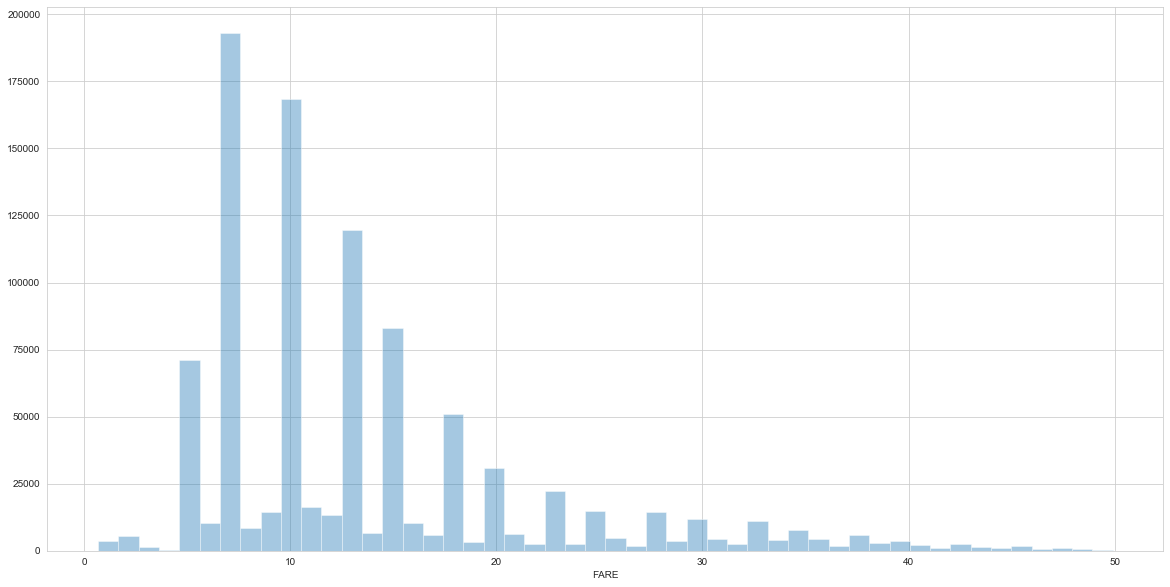

In [68]:
plt.figure(figsize=[20.0, 10.0])
sns.distplot(df.FARE, kde=False)

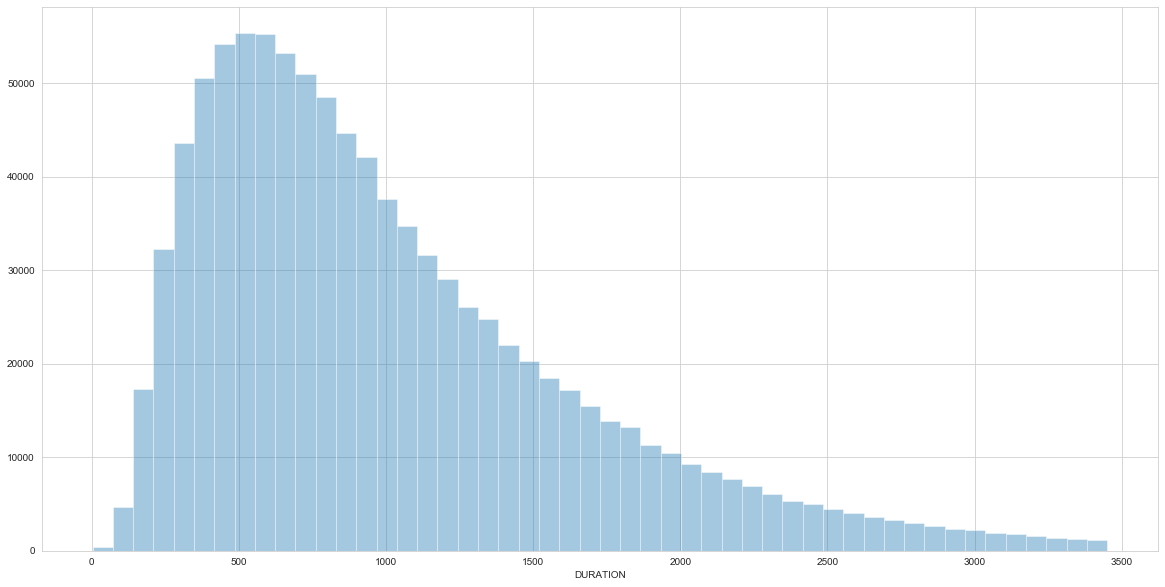

In [69]:
plt.figure(figsize=[20.0, 10.0])
sns.distplot(df.DURATION, kde=False)

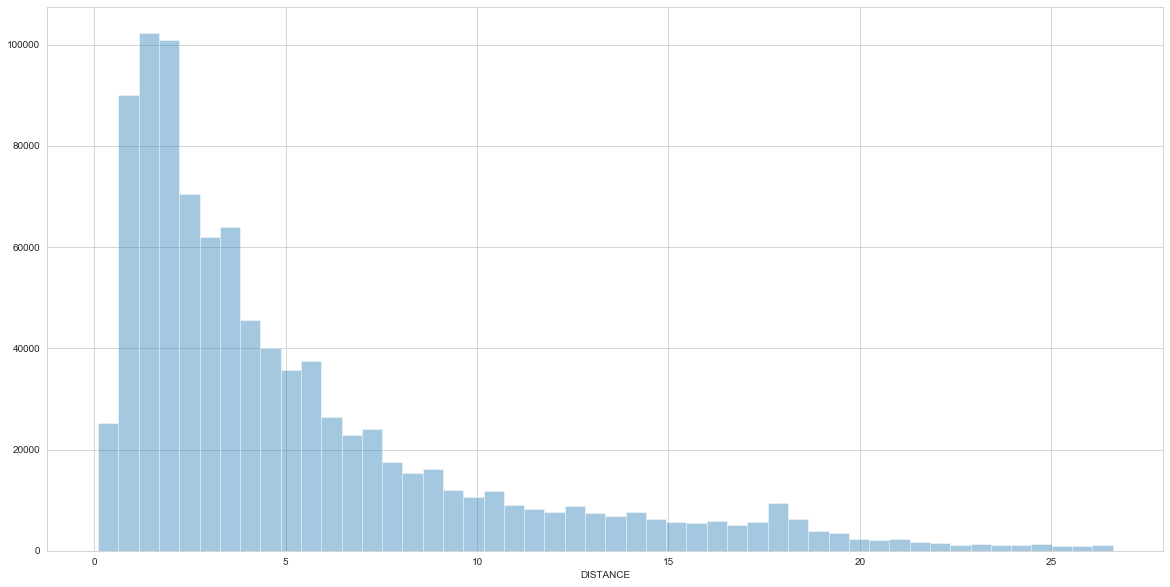

In [70]:
plt.figure(figsize=[20.0, 10.0])
sns.distplot(df.DISTANCE, kde=False)

------------------------------

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score

## Splitting data into training and test data

In [50]:
target = df.FARE
features = df.drop("FARE", axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

## Model Selection

In [51]:
regressors = {
    "Linear Regression": LinearRegression(n_jobs=8),
    "DecisionTree Regression": DecisionTreeRegressor(max_depth=10, random_state=7),
    "RandomForest Regression": RandomForestRegressor(max_depth=10, n_estimators=10, random_state=7, n_jobs=8),
    "Gradient Boosting Regression": GradientBoostingRegressor(n_estimators=250, random_state=7),
    "Linear Support Vector Regression": LinearSVR(tol=1e-4, max_iter=1000, random_state=7),
    "K-Nearest Neighbors Regression": KNeighborsRegressor(n_jobs=8)
}

In [52]:
def run_cross_validations(regressor, features, target):
    try:
        pipeline = Pipeline([
            ("scaler", RobustScaler()),
            ("regressor", regressors.get(regressor)),
        ])
        scores = cross_val_score(pipeline, features, target, cv=KFold(n_splits=5, random_state=0))
        print(f"[{regressor}] Validation Score: {scores.mean() * 100:.2f}% (+/- {scores.std() * 200:.2f}%)")
    except Exception as e:
        print(f"[{regressor}] Validation Error: {e}")

In [27]:
%%time
for reg in regressors:
    run_cross_validations(reg, features, target)

[Linear Regression] Validation Score: 81.22% (+/- 0.13%)
[K Nearest Neighbors Regression] Validation Score: 82.23% (+/- 0.15%)
[DecisionTree Regression] Validation Score: 84.41% (+/- 0.15%)
[RandomForest Regression] Validation Score: 84.58% (+/- 0.13%)
[Gradient Boosting Regression] Validation Score: 84.47% (+/- 0.15%)
[Linear Support Vector Regression] Validation Score: 79.91% (+/- 0.16%)
CPU times: user 1h 14min 26s, sys: 33.3 s, total: 1h 14min 59s
Wall time: 52min 56s


In [99]:
def get_performance_metrics(regressor, train_x, train_y, test_x, test_y):
    # Standardize the data
    scaler = RobustScaler().fit(train_x)
    train_x_std = scaler.transform(train_x)
    test_x_std = scaler.transform(test_x)
    
    # Train the regression model
    regressor.fit(train_x_std, train_y)
    
    # Test the regression model
    pred_y = regressor.predict(test_x_std)
    
    # Calculate the performance metrics
    mae = mean_absolute_error(test_y, pred_y)    # Less is better (min/best=0.0)
    rmse = mean_squared_error(test_y, pred_y)    # Less is better (min/best=0.0)
    r2 = r2_score(test_y, pred_y)                # More is better (max/best=1.0)
    
    title = f"Preformance Metrics for Regression Model: {regressor.__class__}"
    print("-" * len(title))
    print(title.title())
    print("-" * len(title))
    print(f"Mean Absolute Error     : {mae:.2f}")
    print(f"Root Mean Squared Error : {rmse:.2f}")
    print(f"R^2 Score               : {r2:.2f}")

In [13]:
%%time
regressors = {
    "Linear Regression": LinearRegression(n_jobs=8),
    "DecisionTree Regression": DecisionTreeRegressor(max_depth=10, random_state=7),
    "RandomForest Regression": RandomForestRegressor(max_depth=10, n_estimators=10, random_state=7, n_jobs=8),
    "Gradient Boosting Regression": GradientBoostingRegressor(n_estimators=250, random_state=7),
    "Linear Support Vector Regression": LinearSVR(tol=1e-4, max_iter=1000, random_state=7)
}
for _, regression_model in regressors.items():
    get_performance_metrics(regression_model, x_train, y_train, x_test, y_test)
    print("")

Preformance Metrics For Regression Model: <Class 'Sklearn.Linear_Model.Base.Linearregression'>
----------------------------------------------------------------------------------------------
Mean Absolute Error     : 2.49
Root Mean Squared Error : 12.94
R^2 Score               : 0.81
----------------------------------------------------------------------------------------------

Preformance Metrics For Regression Model: <Class 'Sklearn.Tree.Tree.Decisiontreeregressor'>
-------------------------------------------------------------------------------------------
Mean Absolute Error     : 2.17
Root Mean Squared Error : 10.74
R^2 Score               : 0.84
-------------------------------------------------------------------------------------------

Preformance Metrics For Regression Model: <Class 'Sklearn.Ensemble.Forest.Randomforestregressor'>
-------------------------------------------------------------------------------------------------
Mean Absolute Error     : 2.15
Root Mean Squared Erro

**In the above experiments, DecisionTreeRegressor & RandomForestRegressor performed the best. We will select RandomForestRegressor as our model to predict rideshare trip fare which had:** 

**Accuracy                :** *84.58% (+/- 0.13%)*

**Mean Absolute Error     :** *2.15*

**Root Mean Squared Error :** *10.62*

**R^2 Score               :** *0.85*

**Reasons for selecting RandomForestRegressor over DecisionTreeRegressor:**

- Random Forests can handle large amount of data.

- Random Forests are very quick to train.

- Random Forests perform implicit feature selection and provide a pretty good indicator of feature importance.

- Random Forests require almost no input preparation. They can handle binary features, categorical features, numerical features without any need for scaling.

- It’s really hard to build a bad Random Forest! Since random forests are not very sensitive to the specific hyper-parameters used, they don’t require a lot of tweaking and fiddling to get a decent model.

- Random Forest are applicable to a wide variety of modeling tasks, they work well for regression tasks, work very well for classification taks.

- Random Forests can be easily grown in parallel.

------------------

### Performing GridSearch to get the best HyperParameters for RandomForestRegressor

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# Splitting training and test data
target = df.FARE
features = df.drop("FARE", axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=7)

# Standardazing training and test data
scaler = RobustScaler().fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

In [16]:
parameters = {
    "n_estimators": [5, 10, 15, 50, 75, 100],
    "max_depth": [5, 10, 12, 15, 18, 25, 30]
}
parameters

{'n_estimators': [5, 10, 15, 50, 75, 100],
 'max_depth': [5, 10, 12, 15, 18, 25, 30]}

In [17]:
gs = GridSearchCV(
    estimator=RandomForestRegressor(random_state=7),
    param_grid=parameters,
    cv=5,
    n_jobs=8
)

In [18]:
%%time
gs.fit(features, target)

CPU times: user 1min 45s, sys: 1.03 s, total: 1min 46s
Wall time: 40min 47s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'max_depth': [5, 10, 12, 15, 18, 25, 

In [27]:
grid_search_result = pd.DataFrame(gs.cv_results_)
grid_search_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.233104,0.107675,0.143711,0.006516,5,5,"{'max_depth': 5, 'n_estimators': 5}",0.827191,0.826452,0.827079,0.828245,0.828142,0.827422,0.000679,30
1,11.738039,0.111203,0.223073,0.011943,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.828105,0.826859,0.827663,0.829139,0.828728,0.828099,0.000801,29
2,17.560186,0.133086,0.265459,0.014684,5,15,"{'max_depth': 5, 'n_estimators': 15}",0.828030,0.827935,0.827566,0.829760,0.829087,0.828476,0.000817,25
3,58.208812,0.240408,0.676648,0.039062,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.827619,0.827980,0.827558,0.829662,0.828889,0.828342,0.000814,27
4,86.454514,0.887566,0.960724,0.051237,5,75,"{'max_depth': 5, 'n_estimators': 75}",0.827592,0.827933,0.827640,0.829773,0.828836,0.828355,0.000838,26
5,112.305564,1.236964,1.238544,0.056919,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.827611,0.827843,0.827747,0.829725,0.828718,0.828329,0.000799,28
6,10.167020,0.249987,0.230475,0.007455,10,5,"{'max_depth': 10, 'n_estimators': 5}",0.845532,0.844597,0.844935,0.846575,0.845772,0.845482,0.000688,10
7,19.355752,0.203591,0.373707,0.010403,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.845848,0.845077,0.845180,0.846834,0.846215,0.845831,0.000655,8
8,28.040478,0.180063,0.483786,0.027682,10,15,"{'max_depth': 10, 'n_estimators': 15}",0.845980,0.845205,0.845317,0.846954,0.846304,0.845952,0.000646,7
9,92.806331,0.453455,1.381551,0.055798,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.846094,0.845351,0.845363,0.847119,0.846466,0.846078,0.000675,3


In [32]:
grid_search_result[grid_search_result.mean_test_score >= grid_search_result.mean_test_score.max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,179.192687,1.358733,2.38748,0.106826,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.846129,0.845355,0.845381,0.847138,0.846509,0.846102,0.000681,1


In [35]:
print(f"Best test score      : {gs.best_score_}")
print(f"Best hyperparameters : {gs.best_params_}")
print(f"Best regressor model : {gs.best_estimator_}")
print(f"Accuracy             : {gs.best_score_ * 100:.2f}%")

Best test score      : 0.8461022002881495
Best hyperparameters : {'max_depth': 10, 'n_estimators': 100}
Best regressor model : RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=7, verbose=0,
                      warm_start=False)
Accuracy             : 84.61%


From the Grid Search, **n_estimators=100 (Number of decision trees in the Forest), max_depth=10 (Maximum depth of each decision tree)** are found to be the best hyperparameters for our **RandomForestRegressor** model.

In [105]:
best_regressor = gs.best_estimator_
best_hyperparameters = gs.best_params_.copy()
best_hyperparameters["random_state"] = 7
best_hyperparameters["n_jobs"] = 4
best_hyperparameters

{'max_depth': 10, 'n_estimators': 100, 'random_state': 7, 'n_jobs': 4}

In [106]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))
    
    # Plot Grid search scores
    _, ax = plt.subplots(1, 1, figsize=(22, 11))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

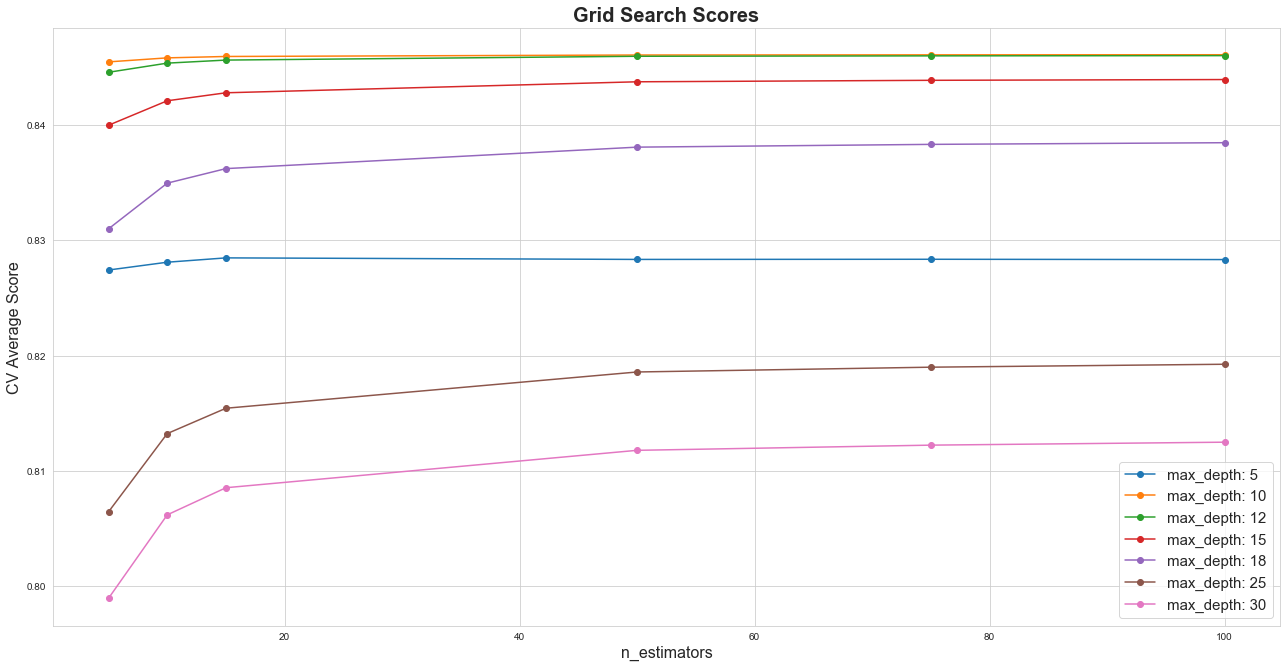

In [107]:
plot_grid_search(
    gs.cv_results_, 
    parameters.get("n_estimators"), 
    parameters.get("max_depth"), 
    "n_estimators", 
    "max_depth"
)

In [108]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=[15, 10])
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

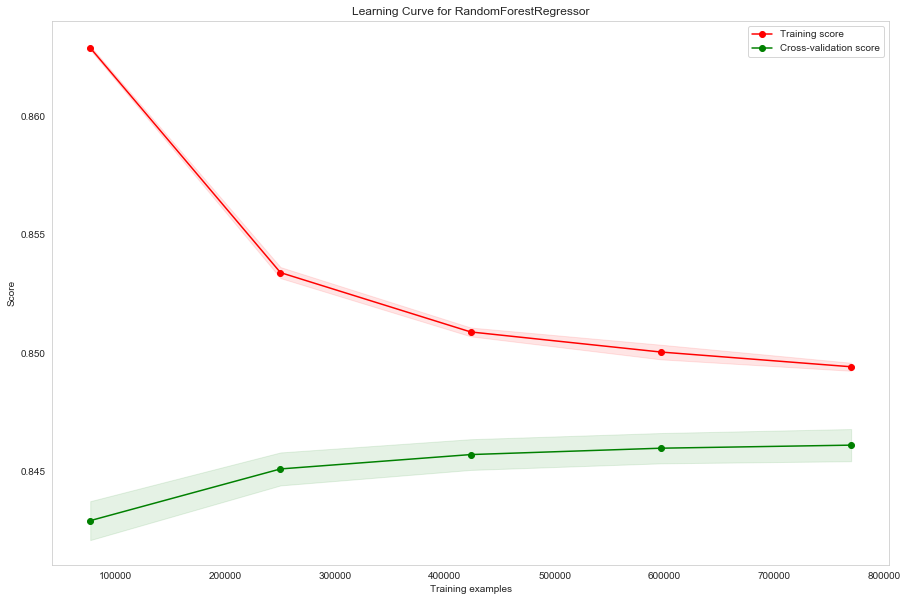

CPU times: user 1.37 s, sys: 290 ms, total: 1.66 s
Wall time: 5min 50s


In [101]:
%%time
graph = plot_learning_curve(
    best_regressor,
    "Learning Curve for RandomForestRegressor",
    features,
    target,
    cv=5,
    n_jobs=8
)
graph.show()

## Building ML pipeline

In [115]:
best_hyperparameters

{'max_depth': 10, 'n_estimators': 100, 'random_state': 7, 'n_jobs': 4}

In [116]:
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("regressor", RandomForestRegressor(**best_hyperparameters))
])

In [117]:
target = df.FARE
features = df.drop("FARE", axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=0)

In [118]:
%%time
pipeline.fit(x_train, y_train)

CPU times: user 2min 8s, sys: 840 ms, total: 2min 9s
Wall time: 32.5 s


Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=10, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=4,
                                       oob_score=False, random_state=7,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [119]:
%%time
y_pred = pipeline.predict(x_test)

CPU times: user 812 ms, sys: 24 ms, total: 836 ms
Wall time: 264 ms


In [126]:
%%time
score = pipeline.score(x_test, y_test)
print(f"Accuracy Score: {score * 100:.2f}%\n")

Accuracy Score: 84.55%

CPU times: user 755 ms, sys: 12.3 ms, total: 768 ms
Wall time: 259 ms


In [127]:
%%time
r2 = r2_score(y_true=y_test, y_pred=y_pred)
rmse = mean_squared_error(y_true=y_test, y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"Mean Absolute Error     : {mae:.2f}")
print(f"Root Mean Squared Error : {rmse:.2f}")
print(f"R^2 Score               : {r2:.2f}\n")

Mean Absolute Error     : 2.15
Root Mean Squared Error : 10.70
R^2 Score               : 0.85

CPU times: user 2.9 ms, sys: 1.08 ms, total: 3.98 ms
Wall time: 2.84 ms


### Prediction of user data

In [128]:
user_data = [
    [801, 3.2, 0, 1],
    [801, 3.2, 1, 2],
    [250, 1.2, 0, 1],
    [345, 1.5, 1, 4]
]

In [129]:
pipeline.predict(user_data)

array([11.33612976,  7.42676163,  7.91064491,  3.89534813])

In [145]:
sub = df[(df.DISTANCE == 3.2) & (df.DURATION >= 447) & (df.DURATION <= 450) & (df.IS_POOLED == 1) & (df.TRIPS_POOLED == 4)]

In [146]:
sub.FARE.mean()

5.05

## Exporting the pipeline be persistent

In [149]:
from pickle import dump

In [150]:
with open("fare_model.pkl", "wb") as fp:
    dump(pipeline, fp)

In [151]:
from joblib import dump

In [152]:
dump(pipeline, "fare_model.joblib", compress=9)

['fare_model.joblib']

In [170]:
dump(pipeline, "fare_model.lzma", compress=("lzma", 9))

['fare_model.lzma']

## Exporting pipeline to open format PMML

In [161]:
from sklearn2pmml import PMMLPipeline

In [162]:
pmml_pipeline = PMMLPipeline([
    ("scaler", RobustScaler()),
    ("regressor", RandomForestRegressor(**best_hyperparameters))
])
target = df.FARE
features = df.drop("FARE", axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=0)

In [163]:
%%time
pmml_pipeline.fit(x_train, y_train)

CPU times: user 2min 3s, sys: 812 ms, total: 2min 4s
Wall time: 31.6 s


PMMLPipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)),
       ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                      oob_score=False, random_state=7, verbose=0,
                      warm_start=False))])

In [164]:
%%time
y_pred = pmml_pipeline.predict(x_test)

CPU times: user 776 ms, sys: 15.8 ms, total: 792 ms
Wall time: 250 ms


In [165]:
%%time
score = pmml_pipeline.score(x_test, y_test)
print(f"Accuracy Score: {score * 100:.2f}%\n")

Accuracy Score: 84.55%

CPU times: user 737 ms, sys: 6.68 ms, total: 744 ms
Wall time: 248 ms


In [166]:
%%time
r2 = r2_score(y_true=y_test, y_pred=y_pred)
rmse = mean_squared_error(y_true=y_test, y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f"Mean Absolute Error     : {mae:.2f}")
print(f"Root Mean Squared Error : {rmse:.2f}")
print(f"R^2 Score               : {r2:.2f}\n")

Mean Absolute Error     : 2.15
Root Mean Squared Error : 10.70
R^2 Score               : 0.85

CPU times: user 2.91 ms, sys: 981 µs, total: 3.89 ms
Wall time: 2.86 ms


In [167]:
sample = df.sample(100000, random_state=7)

In [171]:
pmml_pipeline.verify(sample.drop("FARE", axis=1))

In [172]:
from sklearn2pmml import sklearn2pmml

In [173]:
sklearn2pmml(pmml_pipeline, "fare_model.pmml")

### Clean up

In [174]:
from os import remove

In [175]:
remove("fare_model.pkl")
remove("fare_model.joblib")

-----

### Author

**Maneesh Divana**

**📧 [mdivana@hawk.iit.edu](mailto:mdivana@hawk.iit.edu) ◆ [maneeshd77@gmail.com](mailto:maneeshd77@gmail.com)**

-----